In [1]:
import networkx as nx
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from util import constants
from util.config_util import get_model_params, get_task_params, get_train_params
from tf2_models.trainer import Trainer
from absl import app
from absl import flags

from util.models import MODELS
from util.tasks import TASKS
%matplotlib inline

from attention_graph_util import *

import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 0.0 #set the value globally



chkpt_dir='../tf_ckpts'

task_name = 'word_sv_agreement_vp'
task_params = get_task_params()
task_params.batch_size = 1
task = TASKS[task_name](task_params, data_dir='../data')

Vocab len:  10034


In [2]:
# LSTM to Transformer VP
student_exp_name='samira_fd5'
teacher_exp_name='0.001_samira_offlineteacher_v5'
teacher_config='small_lstm_v4'
student_model='cl_bert'
teacher_model='cl_lstm'
student_config='small_gpt_v9'
distill_config='pure_distill_4_cosinerestart_slow'
distill_mode='offline'

In [ ]:
# LSTM to Transformer VP
student_exp_name='samira_fd7'
teacher_exp_name='0.001_samira_offlineteacher_v5'
teacher_config='small_lstm_v4'
student_model='cl_bert'
teacher_model='cl_lstm'
student_config='short_gpt_v9'
distill_config='pure_distill_4_cosinerestart_slow'
distill_mode='offline'

In [ ]:
# LSTM to Transformer Language Model
student_exp_name='lisa_fd7'
teacher_exp_name='0.001_lisa_offlineteacher_v1'
teacher_config='lstm_drop31_v2'
task_name = 'word_sv_agreement_lm'
student_model='lm_gpt2'
teacher_model='lm_lstm_shared_emb'
student_config='very_big_gpt_v10'
distill_config='pure_distill_4'
distill_mode='offline'



In [ ]:
# LSTM to Transformer VP
student_exp_name='samira_fd1'
teacher_exp_name='0.0001_offlineteacher_v3'
teacher_config='small_lstm_v4'
task_name = 'word_sv_agreement_vp'
student_model='cl_gpt2'
teacher_model='cl_lstm'
student_config='small_gpt_v9'
distill_config='pure_distill_2'
distill_mode='offline'

In [3]:
cl_token = task.databuilder.sentence_encoder().encode(constants.bos)
teacher_model = MODELS[teacher_model](hparams=get_model_params(task, teacher_model, teacher_config), cl_token=cl_token)
std_hparams=get_model_params(task, student_model, student_config)
std_hparams.output_attentions = True
std_hparams.output_hidden_states = True
std_hparams.output_embeddings = True
student_model = MODELS[student_model](
std_hparams, cl_token=cl_token)

model config: small_lstm_v4
{'hidden_dim': 256, 'embedding_dim': 256, 'depth': 2, 'hidden_dropout_rate': 0.8, 'input_dropout_rate': 0.2, 'initializer_range': 0.1}
model config: small_gpt_v9
{'embedding_dim': 128, 'resid_pdrop': 0.4, 'embd_pdrop': 0.2, 'attn_pdrop': 0.6, 'initializer_range': 0.05}


In [4]:
student_ckpt_dir = os.path.join(chkpt_dir, task.name,
                              '_'.join([distill_mode,distill_config,
                                        "teacher", teacher_model.model_name, 
                                        teacher_config,
                                        teacher_exp_name,
                                       "student",student_model.model_name,
                                        str(student_config),
                                        student_exp_name]))
print(student_ckpt_dir)

student_ckpt = tf.train.Checkpoint(net=student_model)
student_manager = tf.train.CheckpointManager(student_ckpt, student_ckpt_dir, max_to_keep=None)

student_ckpt.restore(student_manager.latest_checkpoint)
if student_manager.latest_checkpoint:
  print("Restored student from {}".format(student_manager.latest_checkpoint))
else:
    print("Initialized from sractch")

student_model.compile(loss=task.get_loss_fn(), metrics=task.metrics())

../tf_ckpts/word_sv_agreement_vp/offline_pure_distill_4_cosinerestart_slow_teacher_cl_lstm_em-256_h-256_d-2_hdrop-0.8_indrop-0.2_small_lstm_v4_0.001_samira_offlineteacher_v5_student_cl_bert_h-128_d-6_rdrop-0.4_adrop-0.6_indrop-0.2_small_gpt_v9_samira_fd5
Restored student from ../tf_ckpts/word_sv_agreement_vp/offline_pure_distill_4_cosinerestart_slow_teacher_cl_lstm_em-256_h-256_d-2_hdrop-0.8_indrop-0.2_small_lstm_v4_0.001_samira_offlineteacher_v5_student_cl_bert_h-128_d-6_rdrop-0.4_adrop-0.6_indrop-0.2_small_gpt_v9_samira_fd5/ckpt-60


In [ ]:
viter = iter(task.valid_dataset)


In [19]:
sentence =  '<bos> the black cat that plays with the happy kids <eos>'
#sentence =  '<bos> the black cat which plays with the happy kids <eos>'
sentence = '<bos> the article on NNP large systems <eos>'
#sentence = '<bos> retaining three name , each new ward <eos>'
sentence = '<bos> here the NNP differ in that the female <eos>'
#sentence ='<bos> the key to the cabinets <eos>'
y = [0]
index = 0
#x, y = viter.next()
#sentence =  task.databuilder.sentence_encoder().decode(x[index])#'<bos> the young girl who plays with the older kids is happy <eos>'
print(sentence)

#'<bos> the boys who play football with the old man <eos>'
encoded_sentence = task.databuilder.sentence_encoder().encode(sentence)
logits, extra = student_model.detailed_call(np.asarray([encoded_sentence]), training=False)
outputs, last_state, presents, attentions, embeddings = extra
print(logits)
print(np.argmax(logits), y, (np.argmax(logits) == y))
_attentions = [att.numpy() for att in attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

<bos> here the NNP differ in that the female <eos>
tf.Tensor([[ 3.7687433 -3.3427022]], shape=(1, 2), dtype=float32)
0 [0] [ True]
(6, 8, 11, 11)


In [18]:
np.save('attention_mat_2', attentions_mat)

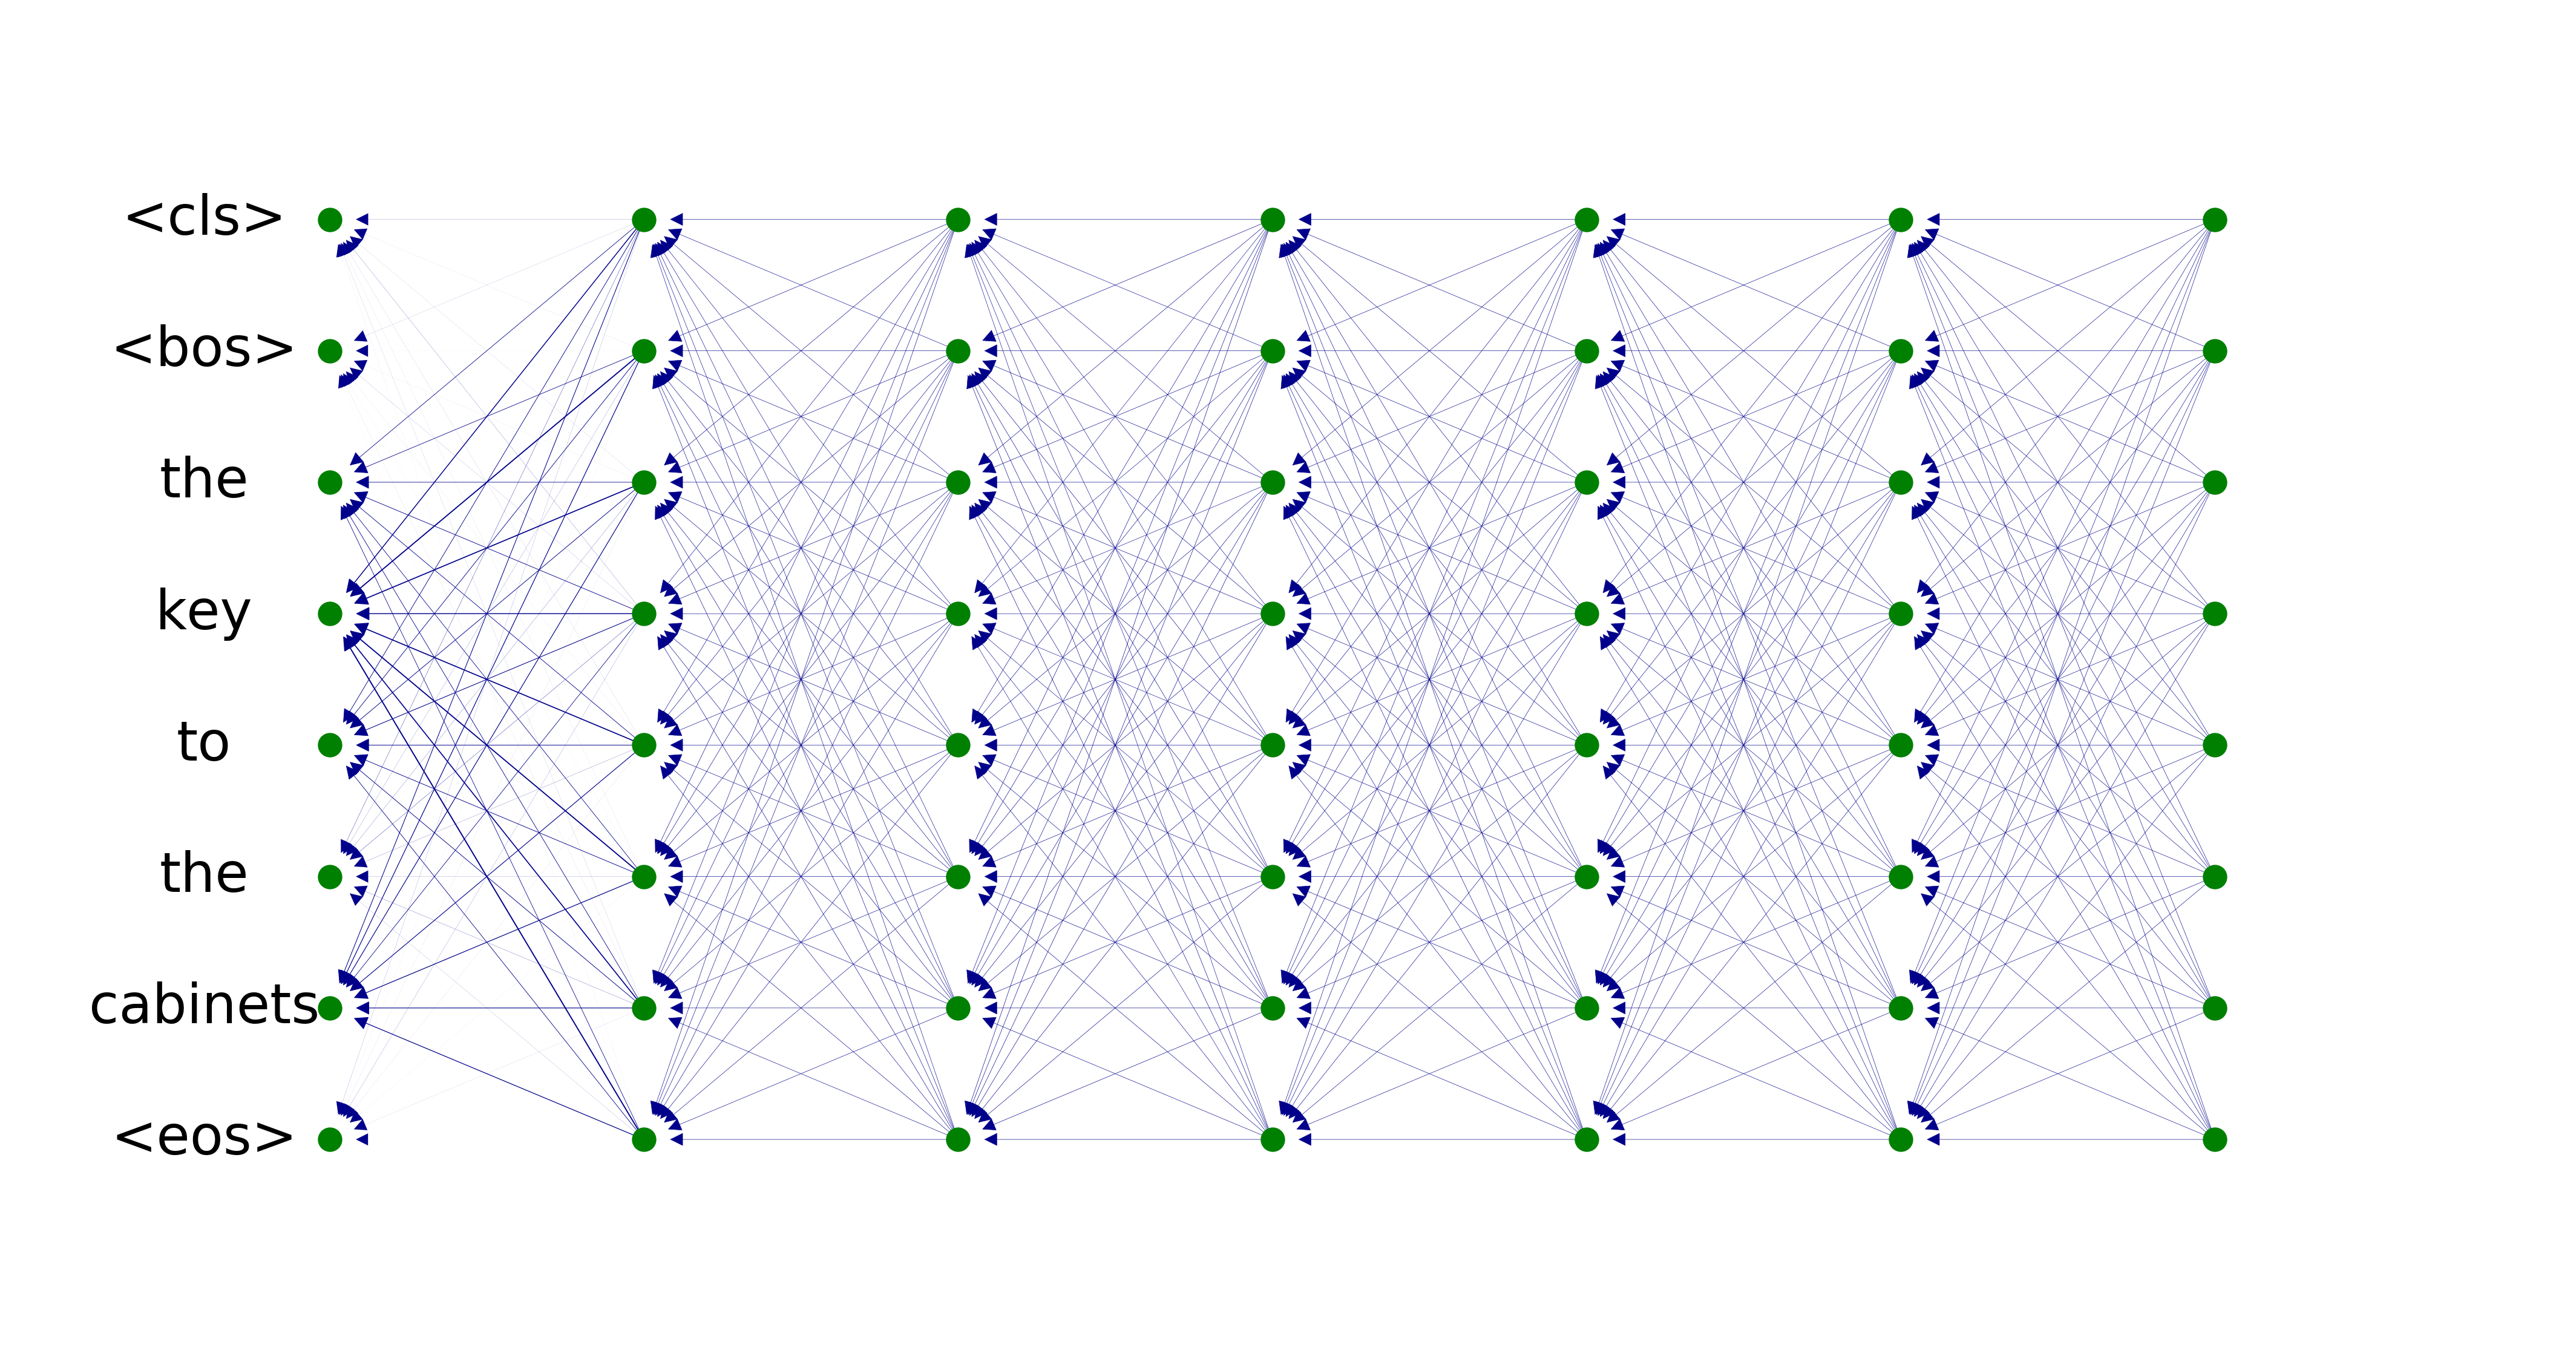

In [6]:
att_mat = attentions_mat.sum(axis=1)/8
new_att_mat = att_mat.copy()
# for i in np.arange(att_mat.shape[0]):
#     new_att_mat[i] = (new_att_mat[i] - np.min(new_att_mat[i]) + 0.000000005) / (np.max(new_att_mat[i]) - np.min(new_att_mat[i]) + 0.00000001)

adj_mat, labels_to_index = get_adjmat(mat=new_att_mat, input_tokens=['<cls>']+sentence.split())

plt.figure(1,figsize=(15,8), dpi=360)
plt.margins(0.15)
G = draw_attention_graph(adj_mat,labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.savefig('rat_deep.pdf', format='pdf', transparent=True, dpi=360)

In [ ]:
for i,(x,y) in enumerate(zip(['<cls>']+sentence.split(), att_mat[-1][0])):
    print("("+str(i)+","+str(y)+")")
    
','.join(['<cls>']+sentence.split())

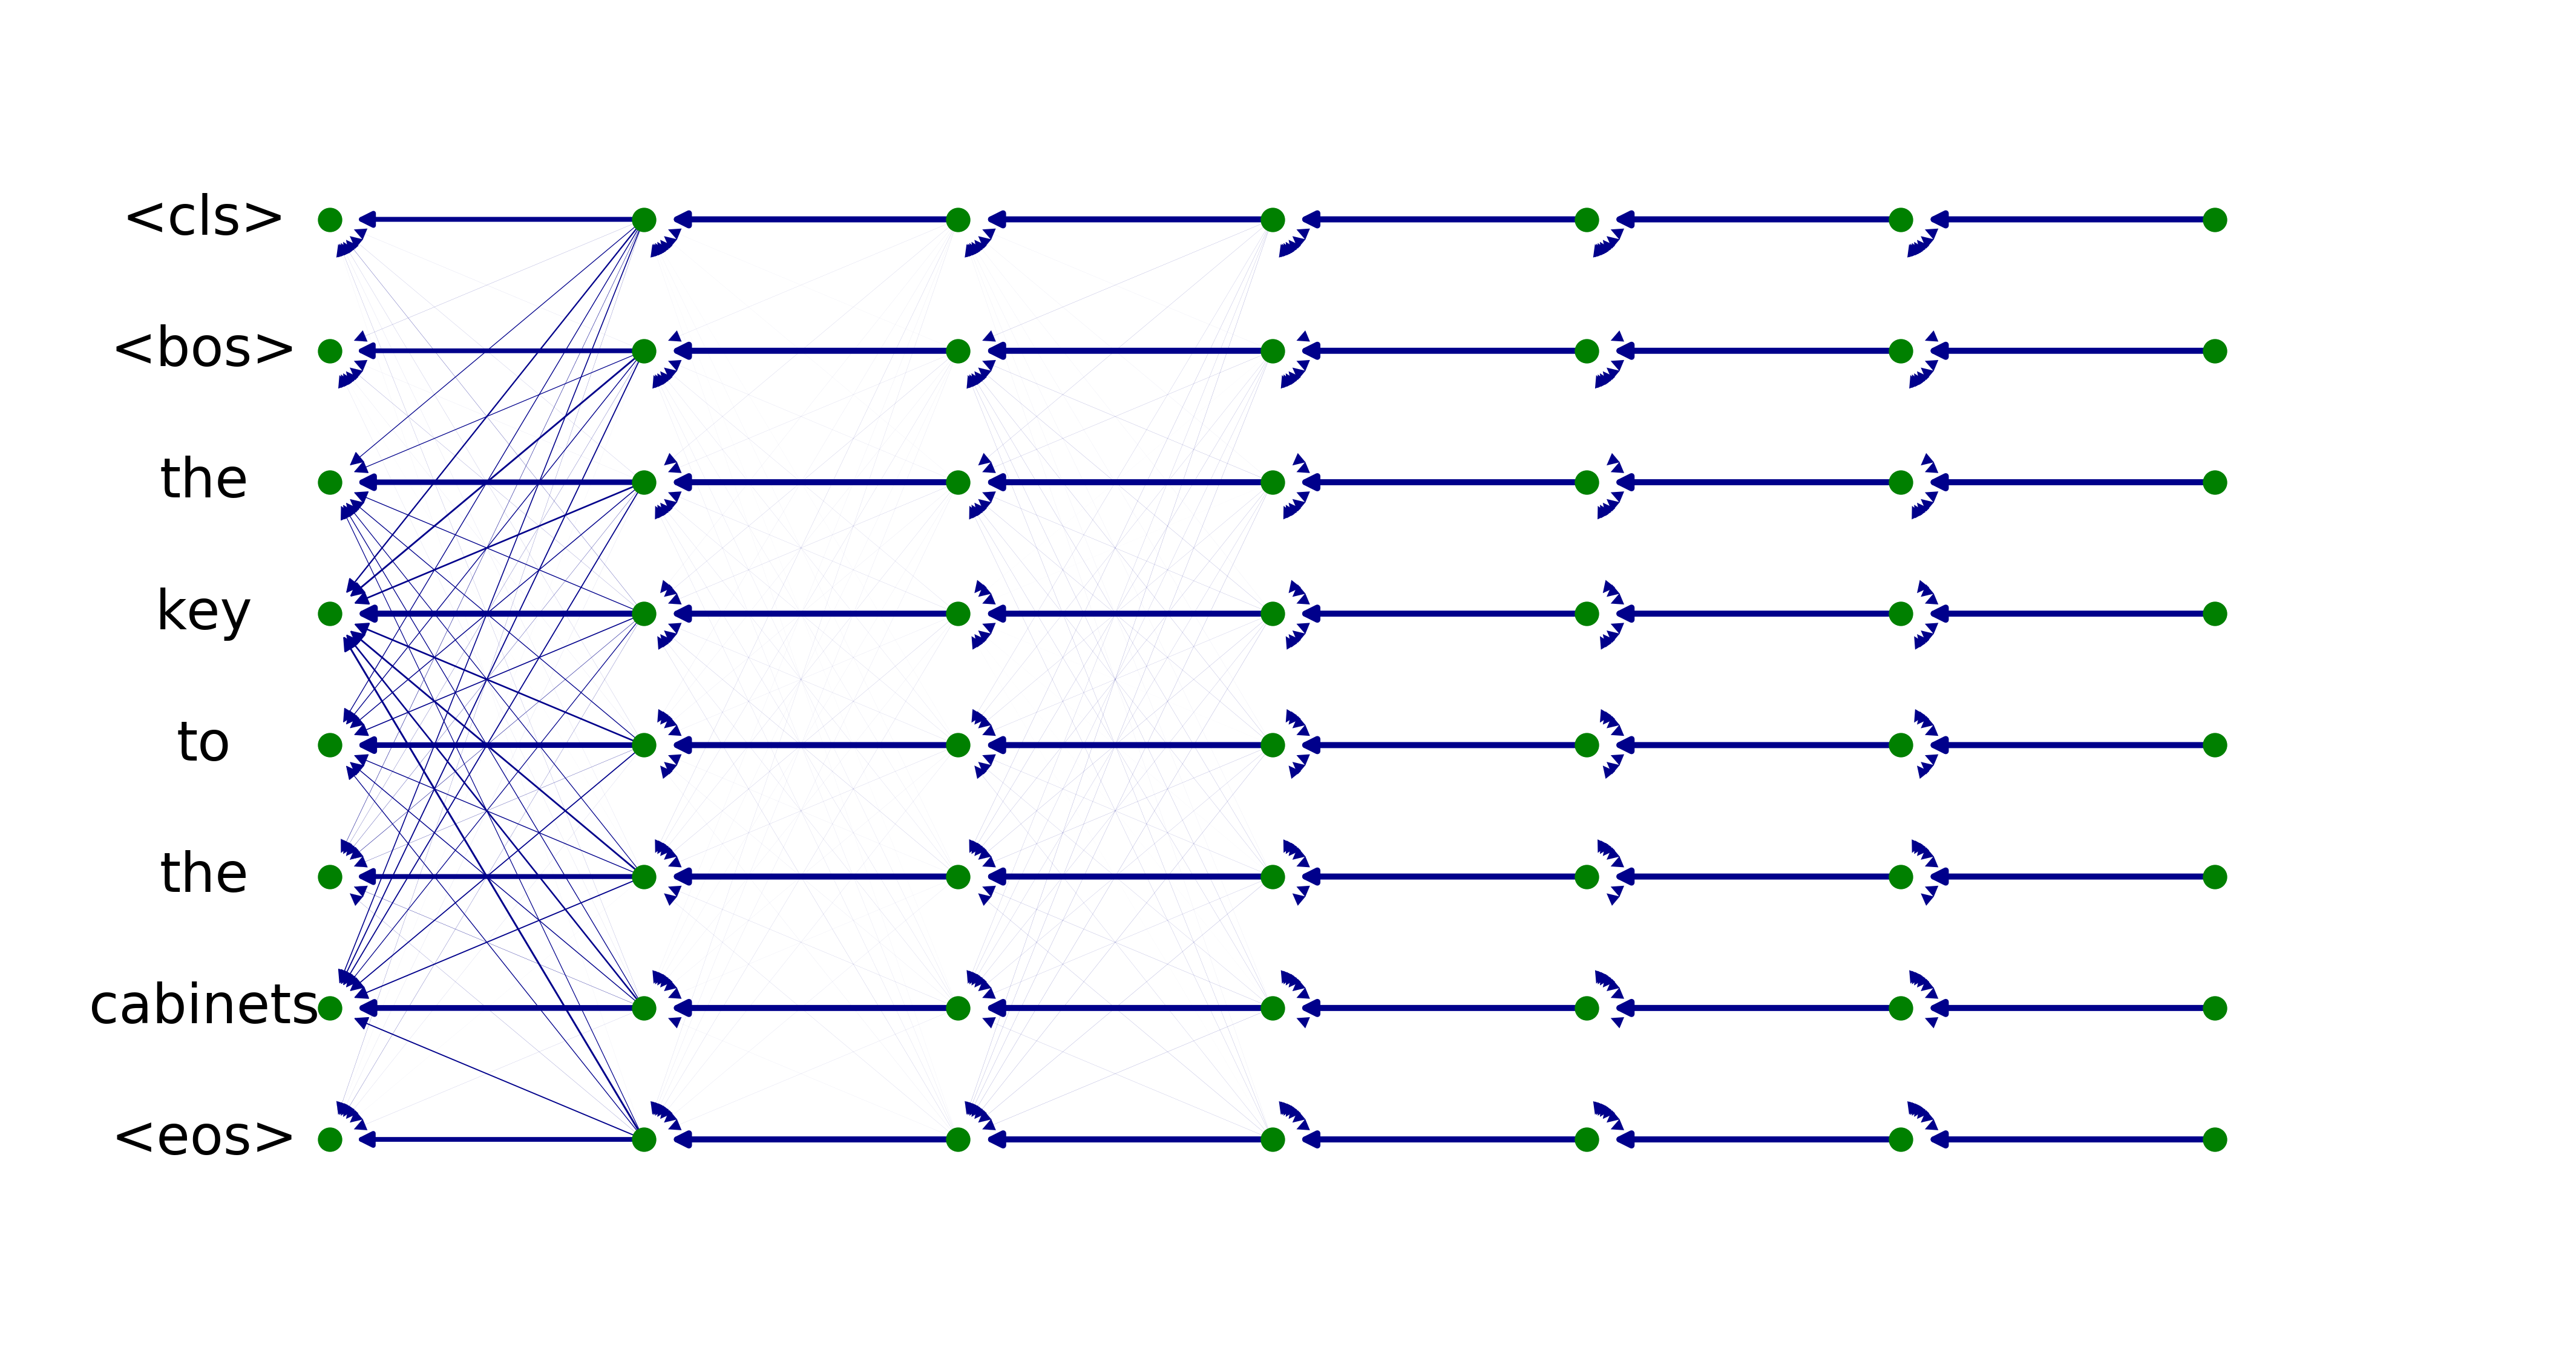

In [14]:
res_att_mat = attentions_mat.sum(axis=1)/8
res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]
 
new_res_att_mat = res_att_mat.copy()
for i in np.arange(att_mat.shape[0]):
    new_res_att_mat[i] = (new_res_att_mat[i] - np.min(new_res_att_mat[i]) + 0.000000005) / (np.max(new_res_att_mat[i]) - np.min(new_res_att_mat[i]) + 0.00000001)

    
res_adj_mat, res_labels_to_index = get_adjmat(mat=new_res_att_mat, input_tokens=['<cls>']+sentence.split())

plt.figure(1,figsize=(15,8), dpi=360)
plt.margins(0.15)
res_G = draw_attention_graph(res_adj_mat*2,res_labels_to_index, n_layers=new_res_att_mat.shape[0], length=res_att_mat.shape[-1])
plt.savefig('res_rat_deep.pdf', format='pdf', transparent=True, dpi=360)

In [ ]:
res_att_mat[-1][0]

(6, 8, 8)


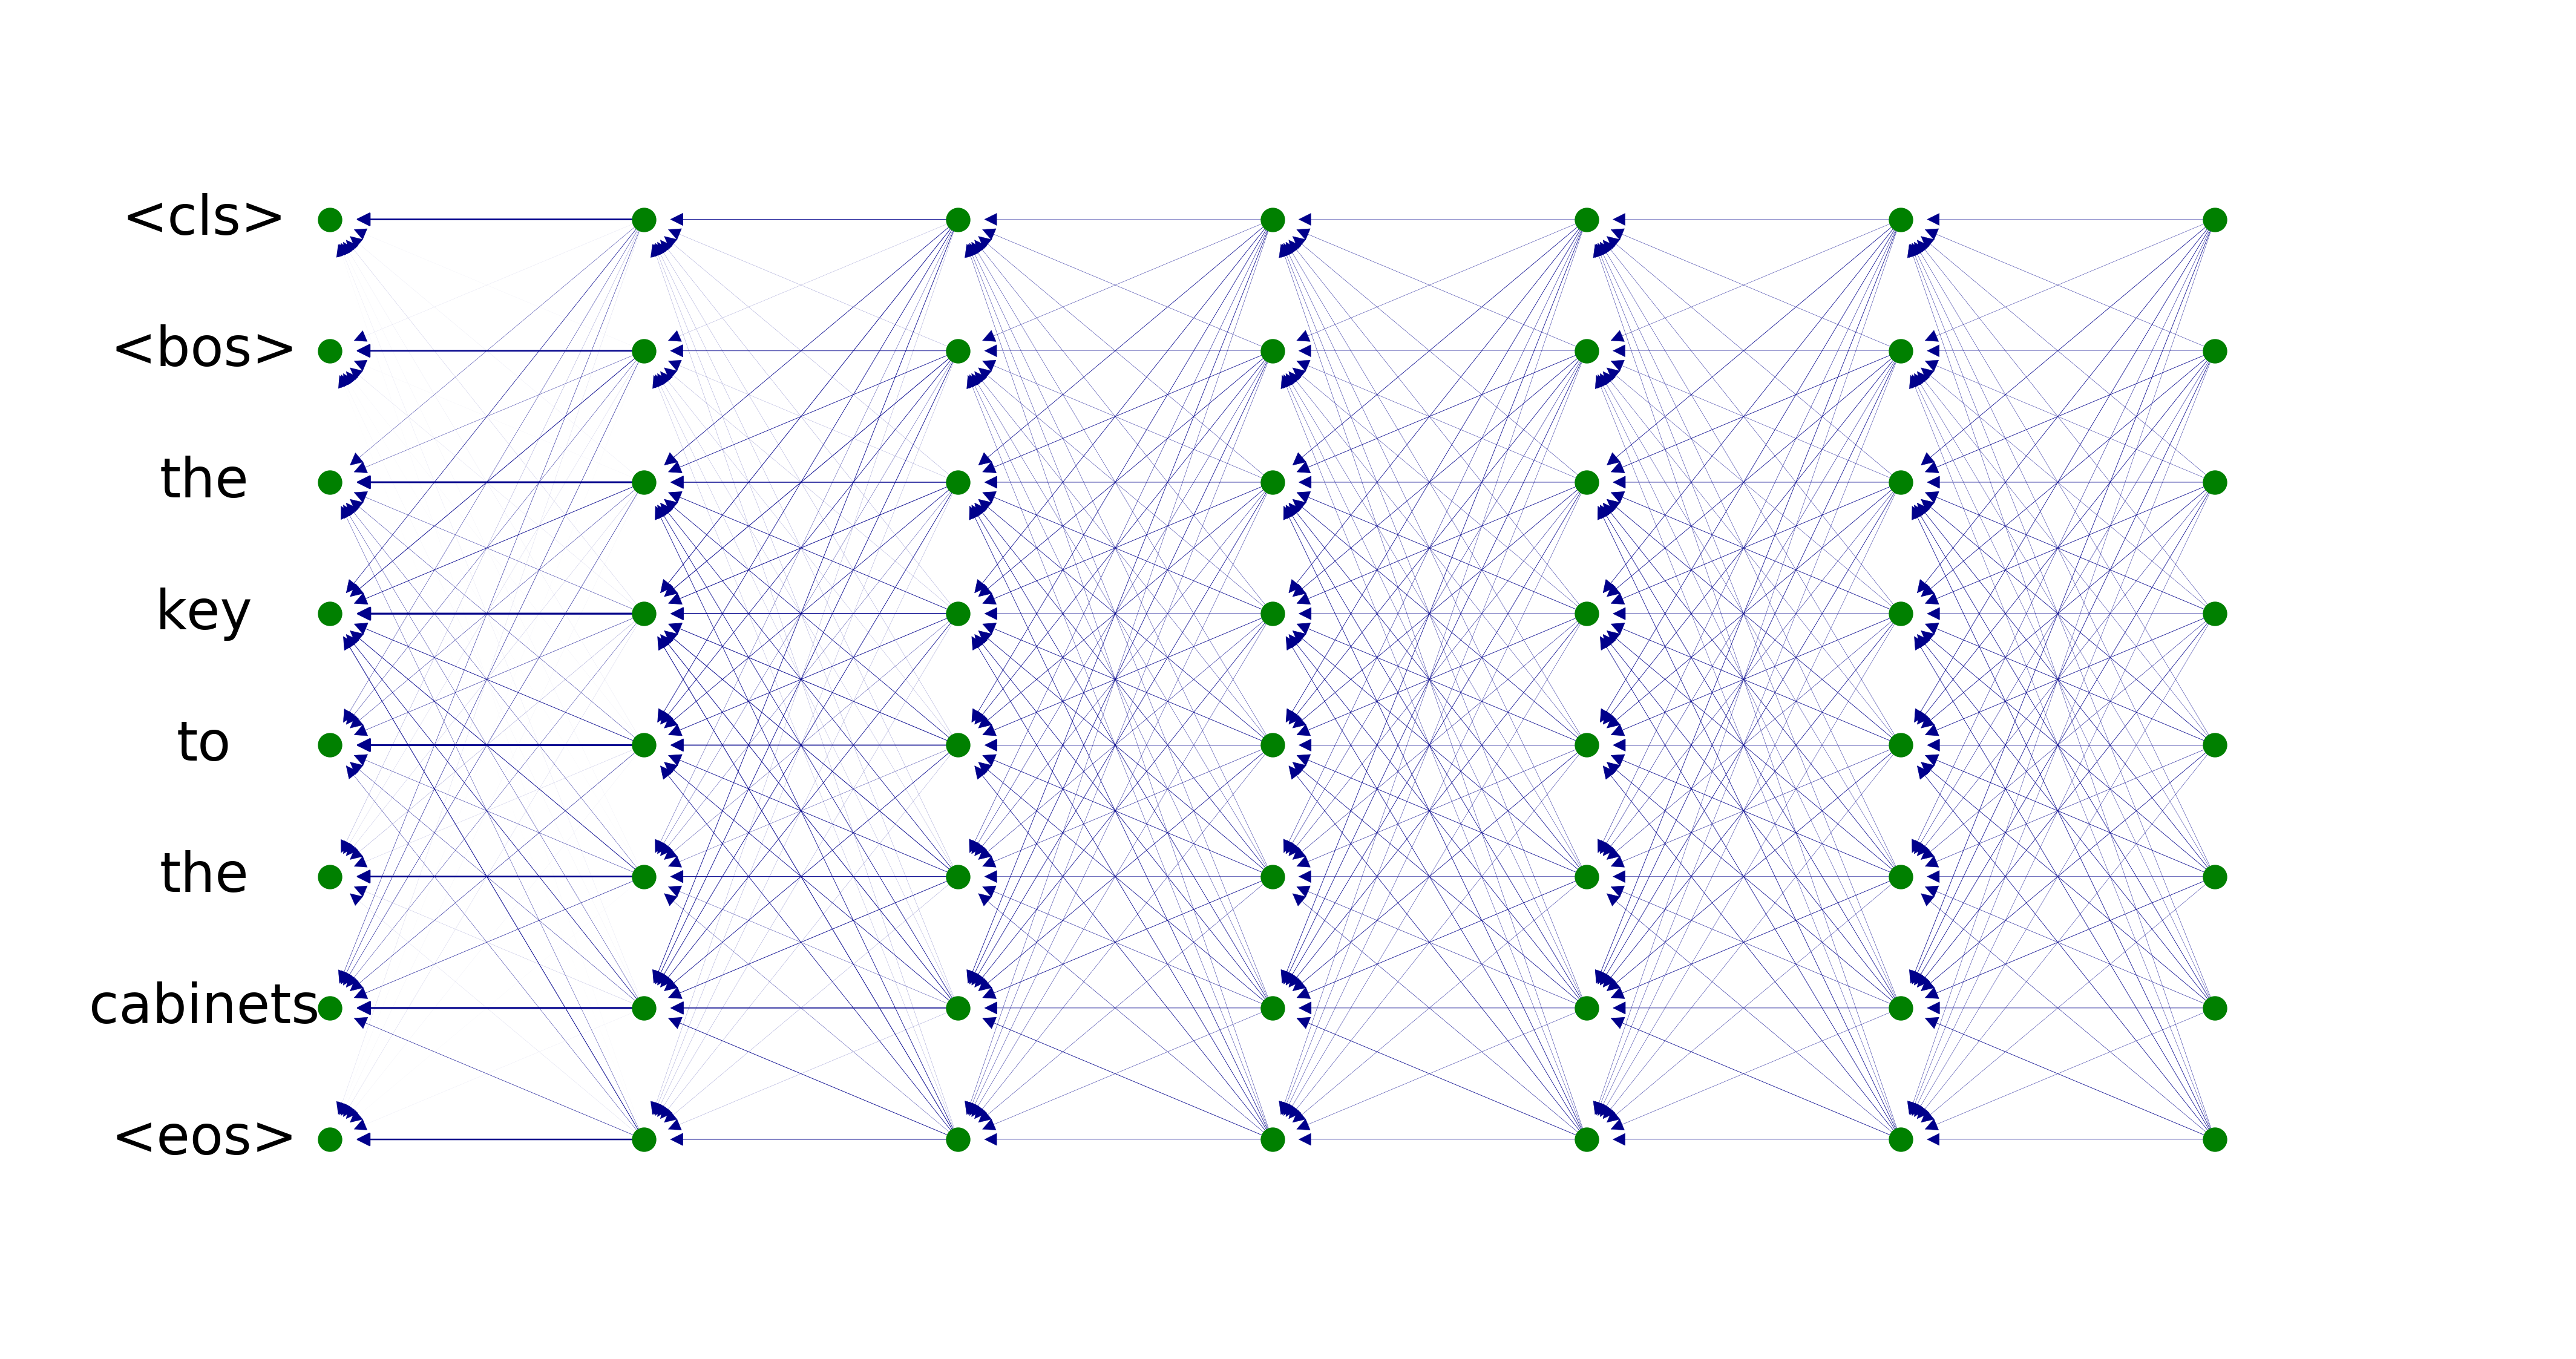

In [8]:
def convert_adjmat_tomats(adjmat, n_layers, l):
    mats = np.zeros((n_layers,l,l))
    
    for i in np.arange(n_layers):
        mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]
        
    return mats
    

output_nodes = []
input_nodes = []
for key in labels_to_index:
    if 'L6' in key:
        output_nodes.append(key)
    if labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])

flow_mats = convert_adjmat_tomats(flow_values, 6, attentions_mat.shape[-1])
print(flow_mats.shape)
# flow_mats = flow_mats.copy()
# for i in np.arange(att_mat.shape[0]):
#     flow_mats[i] = (flow_mats[i] - np.min(flow_mats[i]) + 0.000000005) / (np.max(flow_mats[i]) - np.min(flow_mats[i]) + 0.00000001)

flow_values, labels_to_index = get_adjmat(mat=flow_mats, input_tokens=['<cls>']+sentence.split())
   
plt.figure(1,figsize=(15,8), dpi=360)
plt.margins(0.15)
flow_G = draw_attention_graph(flow_values,labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.savefig('res_fat_deep.pdf', format='pdf', transparent=True, dpi=360)

In [ ]:
n_l = 6
length = res_att_mat.shape[-1]
for i,(x,y) in enumerate(zip(['<cls>']+sentence.split(),flow_values[(n_l)*length:,(n_l-1)*length:n_l*length][0])):
    print("("+str(i)+","+str(y)+")")
    
','.join(['<cls>']+sentence.split())

In [ ]:
n_l = 6
length = res_att_mat.shape[-1]
for i,(x,y) in enumerate(zip(['<cls>']+sentence.split(),flow_values[(n_l)*length:,(n_l-1)*length:n_l*length][0])):
    print("("+str(i)+","+str(y)+")")
    
','.join(['<cls>']+sentence.split())

In [ ]:
joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=['<cls>']+sentence.split())


plt.figure(1,figsize=(15,8), dpi=360)
plt.margins(0.15)
G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])
plt.savefig('res_jat_deep.pdf', format='pdf', transparent=True, dpi=360)

In [ ]:
for i,(x,y) in enumerate(zip(['<cls>']+sentence.split(), joint_attentions[-1][0])):
    print("("+str(i)+","+str(y)+")")
    
','.join(['<cls>']+sentence.split())

In [ ]:
for x,y in zip(['<cls>']+sentence.split(), joint_attentions[-1][0]):
    print("("+x+","+str(y)+")")
    
','.join(['<cls>']+sentence.split())